In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import os
import sys
import torch

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
sys.path.append('..')

from cifar100cnn.data import get_cifar_data
from cifar100cnn.extractor import *
from cifar100cnn.load_models import MODEL_PATHS, load_model

In [61]:
train_loader, val_loader, test_loader, class_names = get_cifar_data(num_classes=100, augment=True)
class_dict = {idx: name for idx, name in enumerate(class_names)}

class_dict

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Saved class names to class_names.txt


{0: 'apple',
 1: 'aquarium_fish',
 2: 'baby',
 3: 'bear',
 4: 'beaver',
 5: 'bed',
 6: 'bee',
 7: 'beetle',
 8: 'bicycle',
 9: 'bottle',
 10: 'bowl',
 11: 'boy',
 12: 'bridge',
 13: 'bus',
 14: 'butterfly',
 15: 'camel',
 16: 'can',
 17: 'castle',
 18: 'caterpillar',
 19: 'cattle',
 20: 'chair',
 21: 'chimpanzee',
 22: 'clock',
 23: 'cloud',
 24: 'cockroach',
 25: 'couch',
 26: 'crab',
 27: 'crocodile',
 28: 'cup',
 29: 'dinosaur',
 30: 'dolphin',
 31: 'elephant',
 32: 'flatfish',
 33: 'forest',
 34: 'fox',
 35: 'girl',
 36: 'hamster',
 37: 'house',
 38: 'kangaroo',
 39: 'keyboard',
 40: 'lamp',
 41: 'lawn_mower',
 42: 'leopard',
 43: 'lion',
 44: 'lizard',
 45: 'lobster',
 46: 'man',
 47: 'maple_tree',
 48: 'motorcycle',
 49: 'mountain',
 50: 'mouse',
 51: 'mushroom',
 52: 'oak_tree',
 53: 'orange',
 54: 'orchid',
 55: 'otter',
 56: 'palm_tree',
 57: 'pear',
 58: 'pickup_truck',
 59: 'pine_tree',
 60: 'plain',
 61: 'plate',
 62: 'poppy',
 63: 'porcupine',
 64: 'possum',
 65: 'rabbit',

In [62]:
classes_A = np.arange(50)
classes_B = np.arange(50, 100)

models = {name: load_model(name, "../" + path, device) for name, path in MODEL_PATHS.items()}
feature_extractor = FeatureExtractor(device)

..\cifar100cnn\load_models.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [ ]:
def calculate_accuracy(model, representative, test_loader, class_type, test_features_path, test_labels_path, knn_k):
    test_features = np.load(test_features_path)
    test_labels = np.load(test_labels_path)

    mask_test = np.isin(test_labels, class_type)
    test_features, test_labels_A = test_features[mask_test], test_labels[mask_test]

    predictions = classify_knn(test_features, representative, knn_k)
    accuracy = evaluate_accuracy(predictions, test_labels_A)

    return accuracy

In [64]:
def plot_stage(ax, features_pca, classes, accuracy, stage_name, num_samples):
    scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=classes, cmap='tab20', s=100, alpha=0.8)
    ax.set_title(f"{stage_name} ({num_samples} próbek/klasę)\nAccuracy: {accuracy:.2f}%")
    ax.set_xticks([])
    ax.set_yticks([])

    for i, txt in enumerate(classes):
        ax.text(features_pca[i, 0], features_pca[i, 1], class_dict[txt], fontsize=9)

In [65]:
# creates plots for stage A and B (above and below)

def plot_stages(pca_results_A, pca_results_B, classes_list_A, classes_list_B, 
                            accuracies_A, accuracies_B, model_name, class_dict):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    sample_counts = [1, 5, 10]

    # A:
    for col, num_samples in enumerate(sample_counts):
        idx = sample_counts.index(num_samples)
        plot_stage(axs[0, col], pca_results_A[idx], classes_list_A[idx], accuracies_A[idx], "Etap A", num_samples)

    # B:
    for col, num_samples in enumerate(sample_counts):
        idx = sample_counts.index(num_samples)
        plot_stage(axs[1, col], pca_results_B[idx], classes_list_B[idx], accuracies_B[idx], "Etap B", num_samples)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Model: {model_name}", fontsize=16)
    plt.show()

In [66]:
base_dir_A = os.path.join("..", "cache/etap2")
base_dir_B = os.path.join("..", "cache/etap3")

models_names = ["resnet18_scratch", "resnet18_fine_tuned", "resnet50_scratch", "resnet50_fine_tuned", "wide_resnet"]
nums_samples = [1, 5, 10]

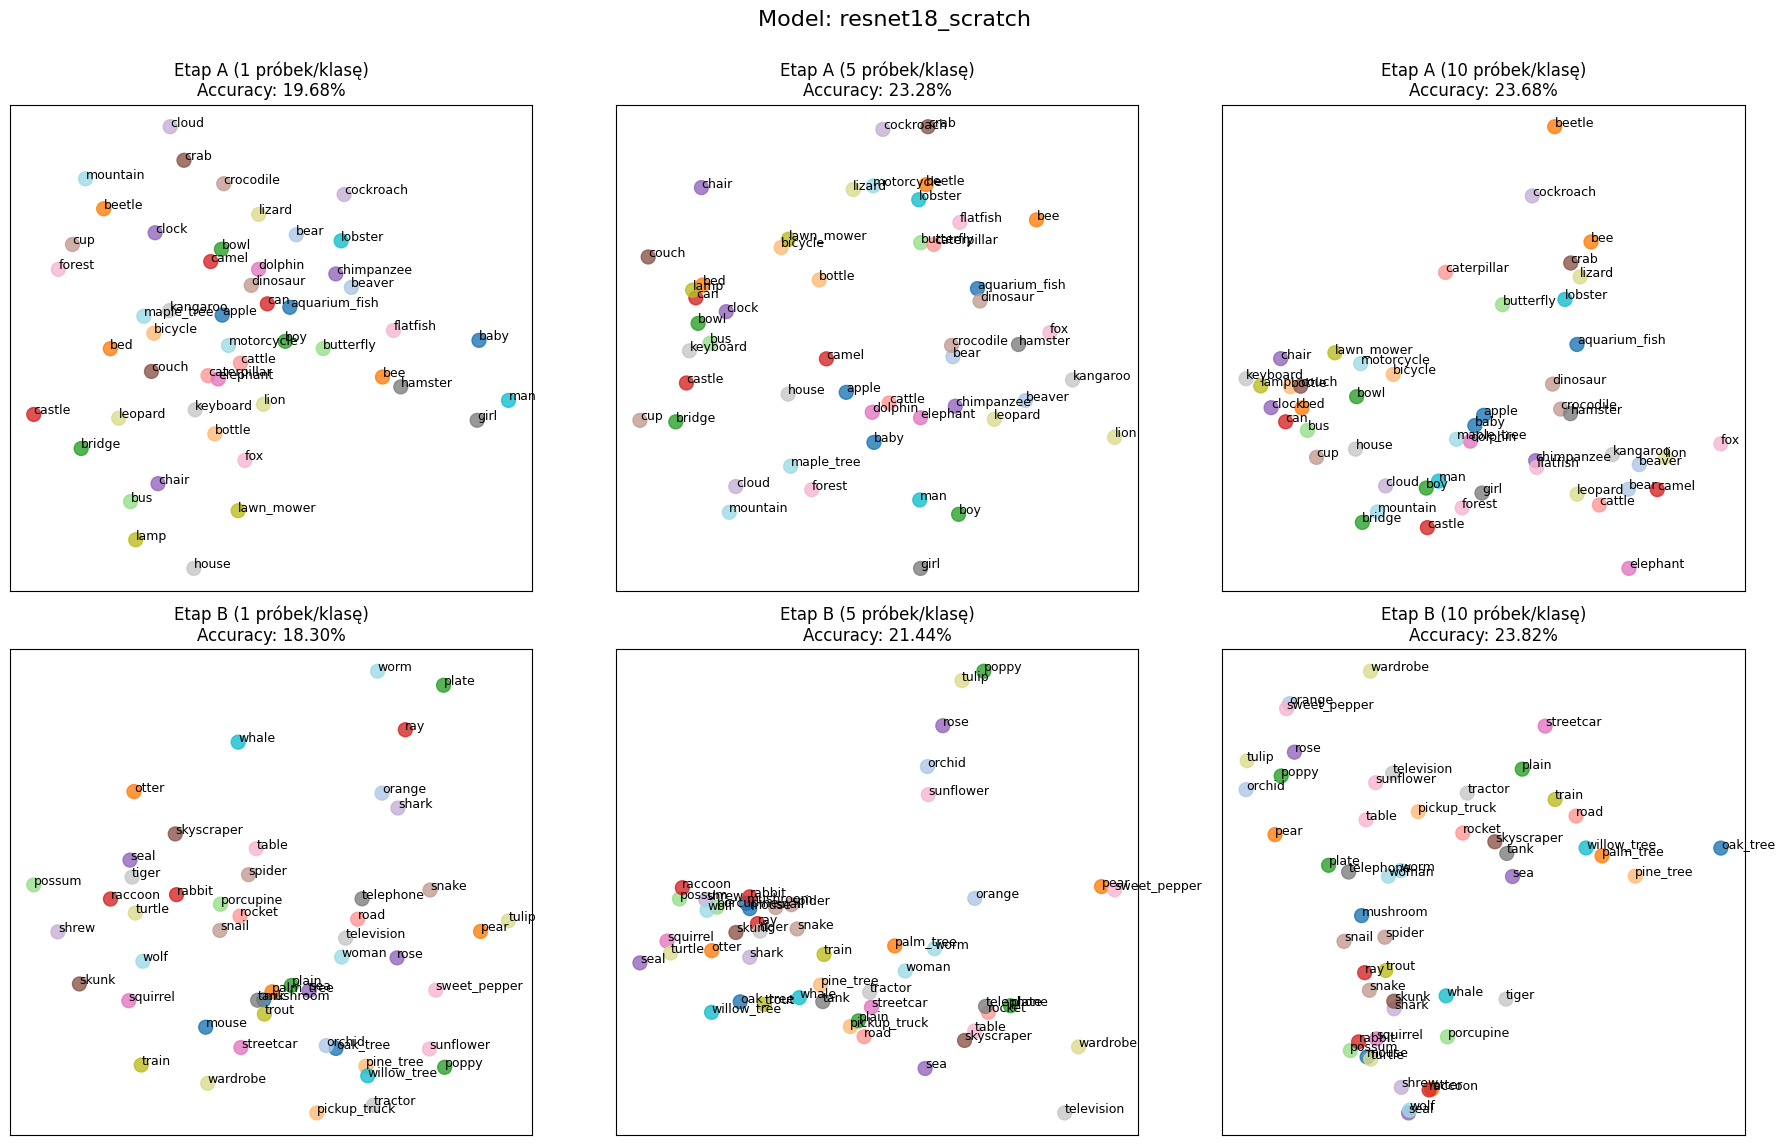

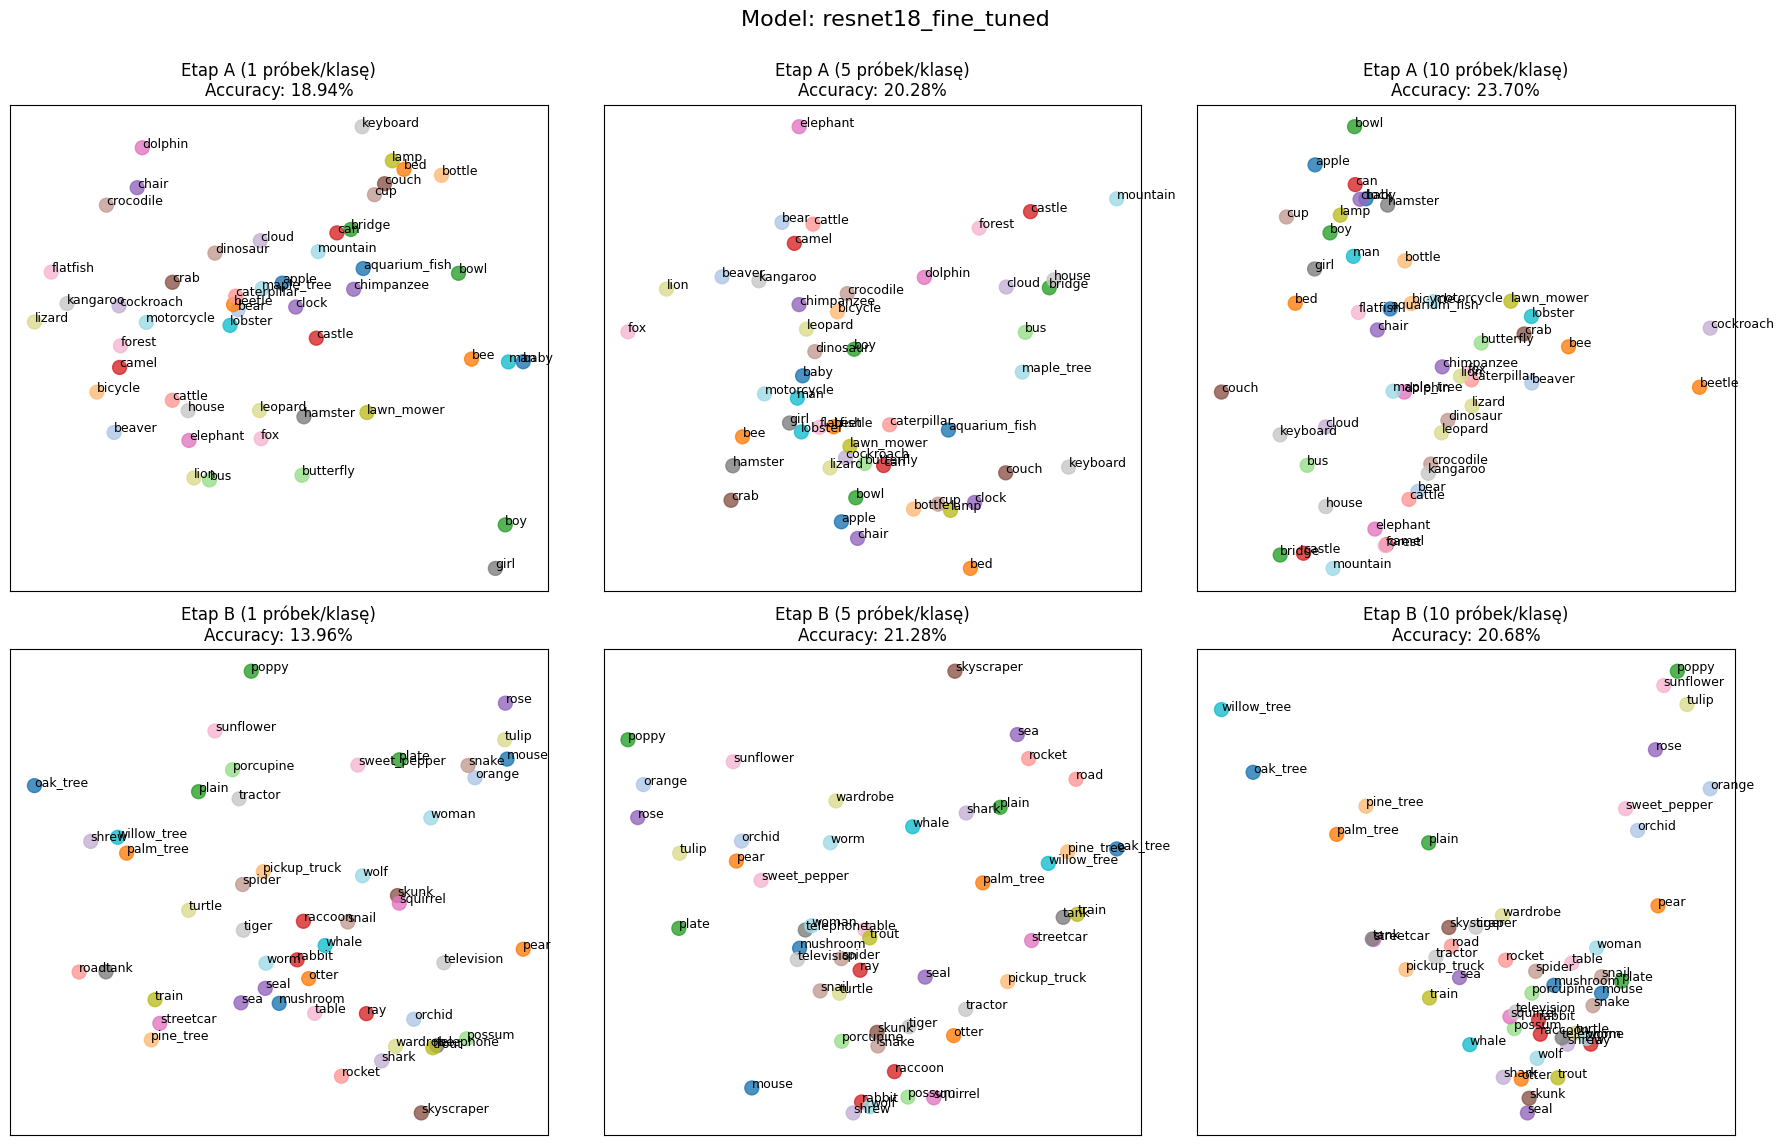

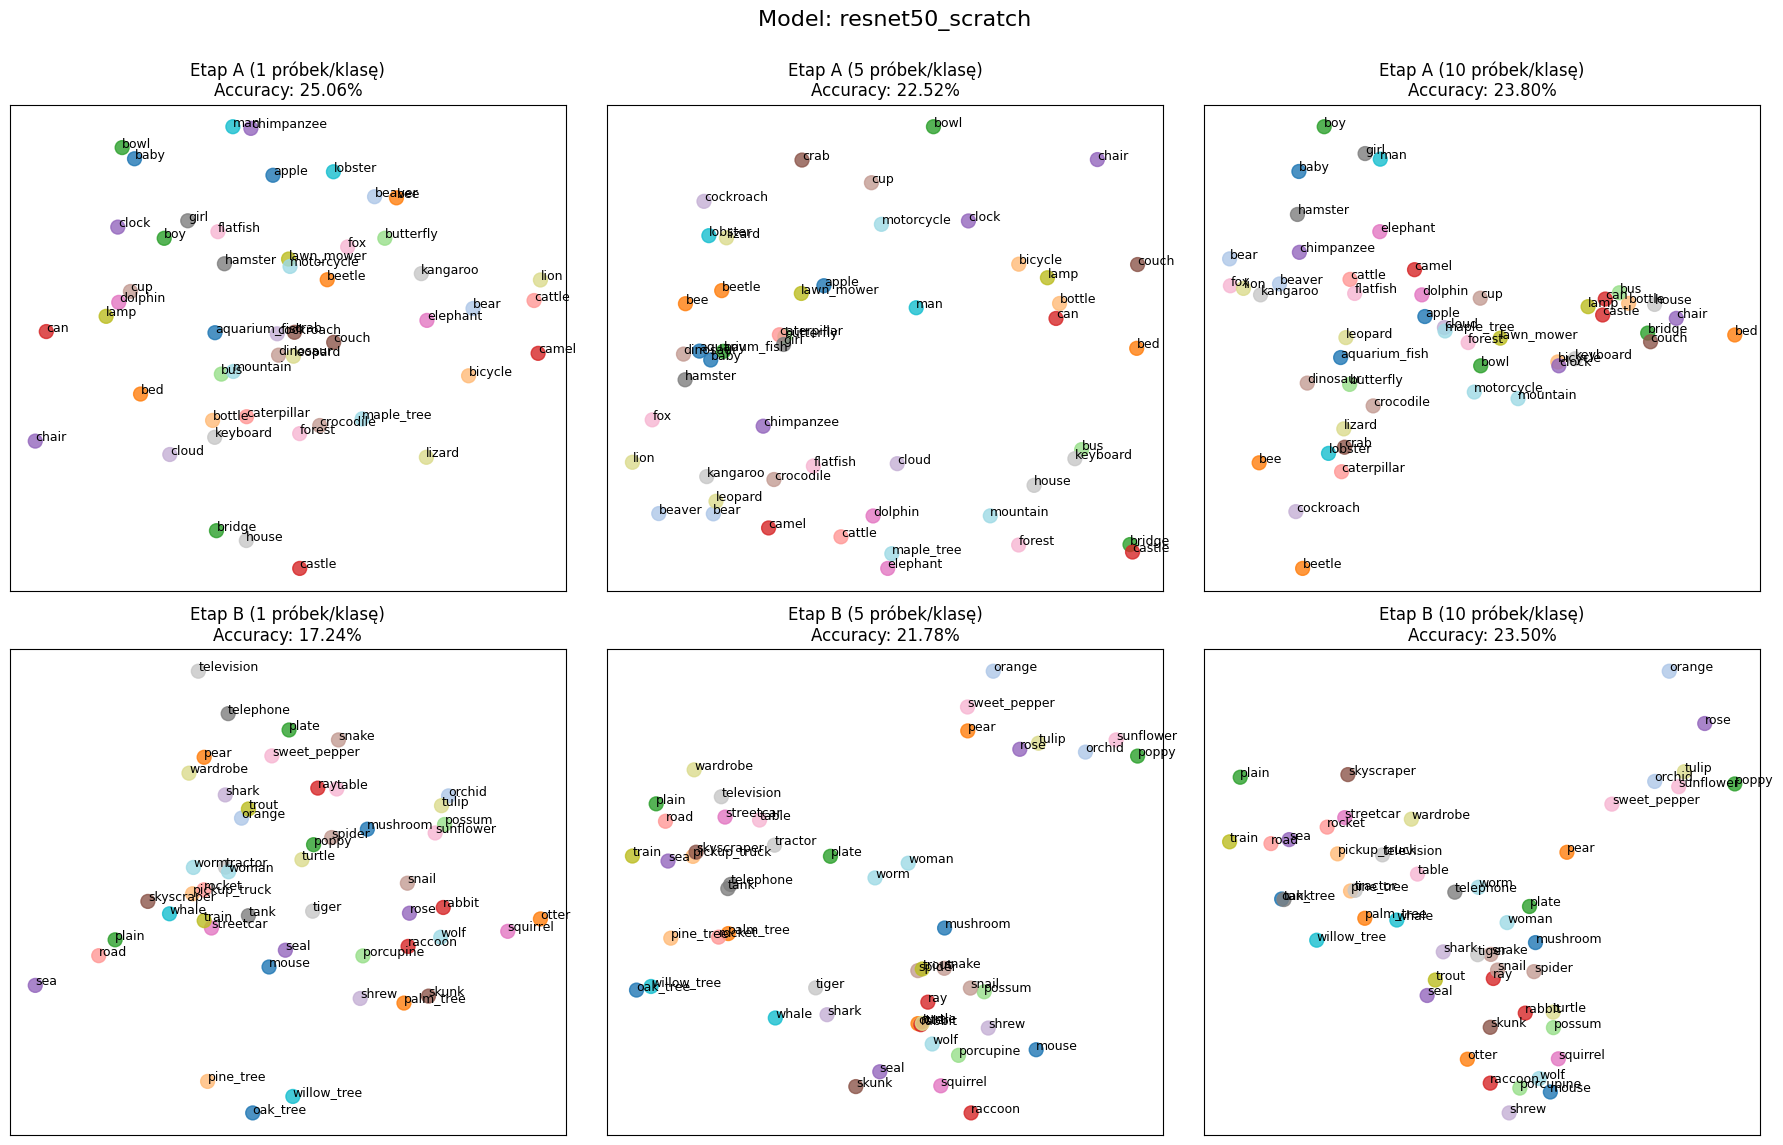

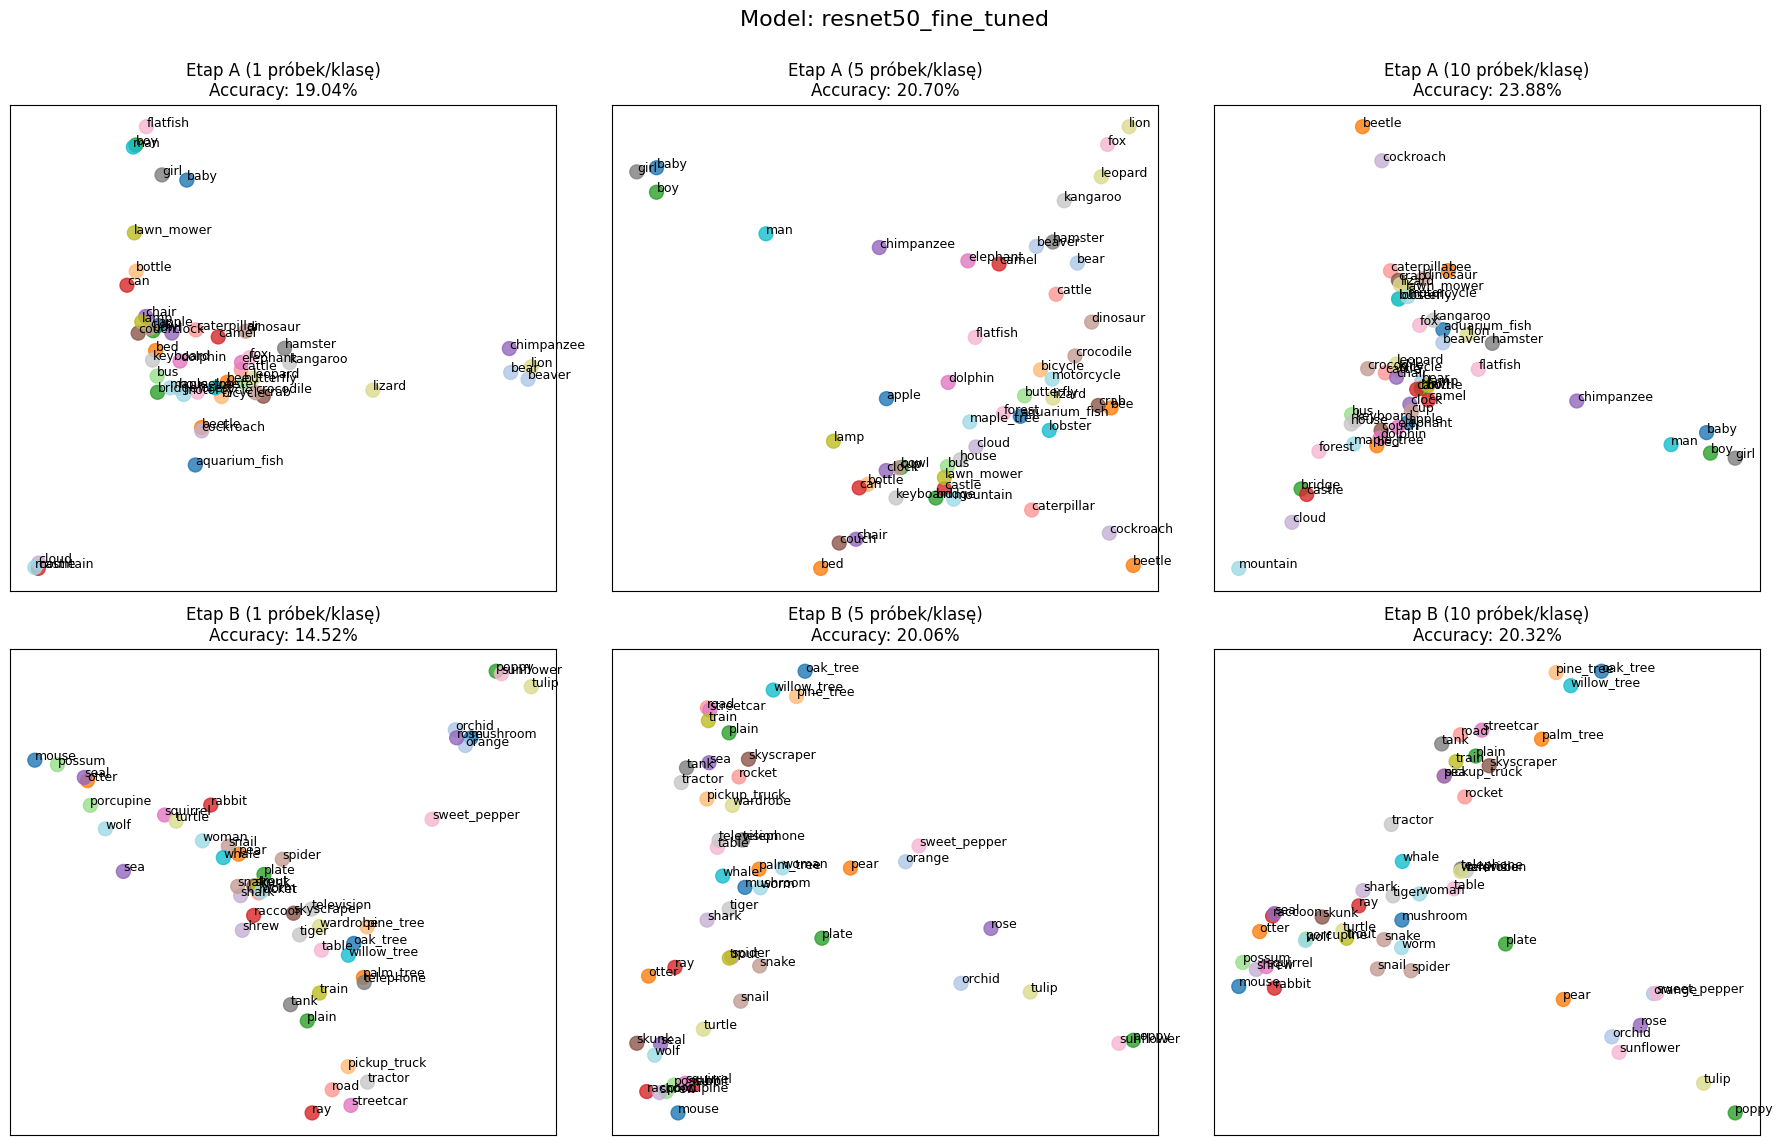

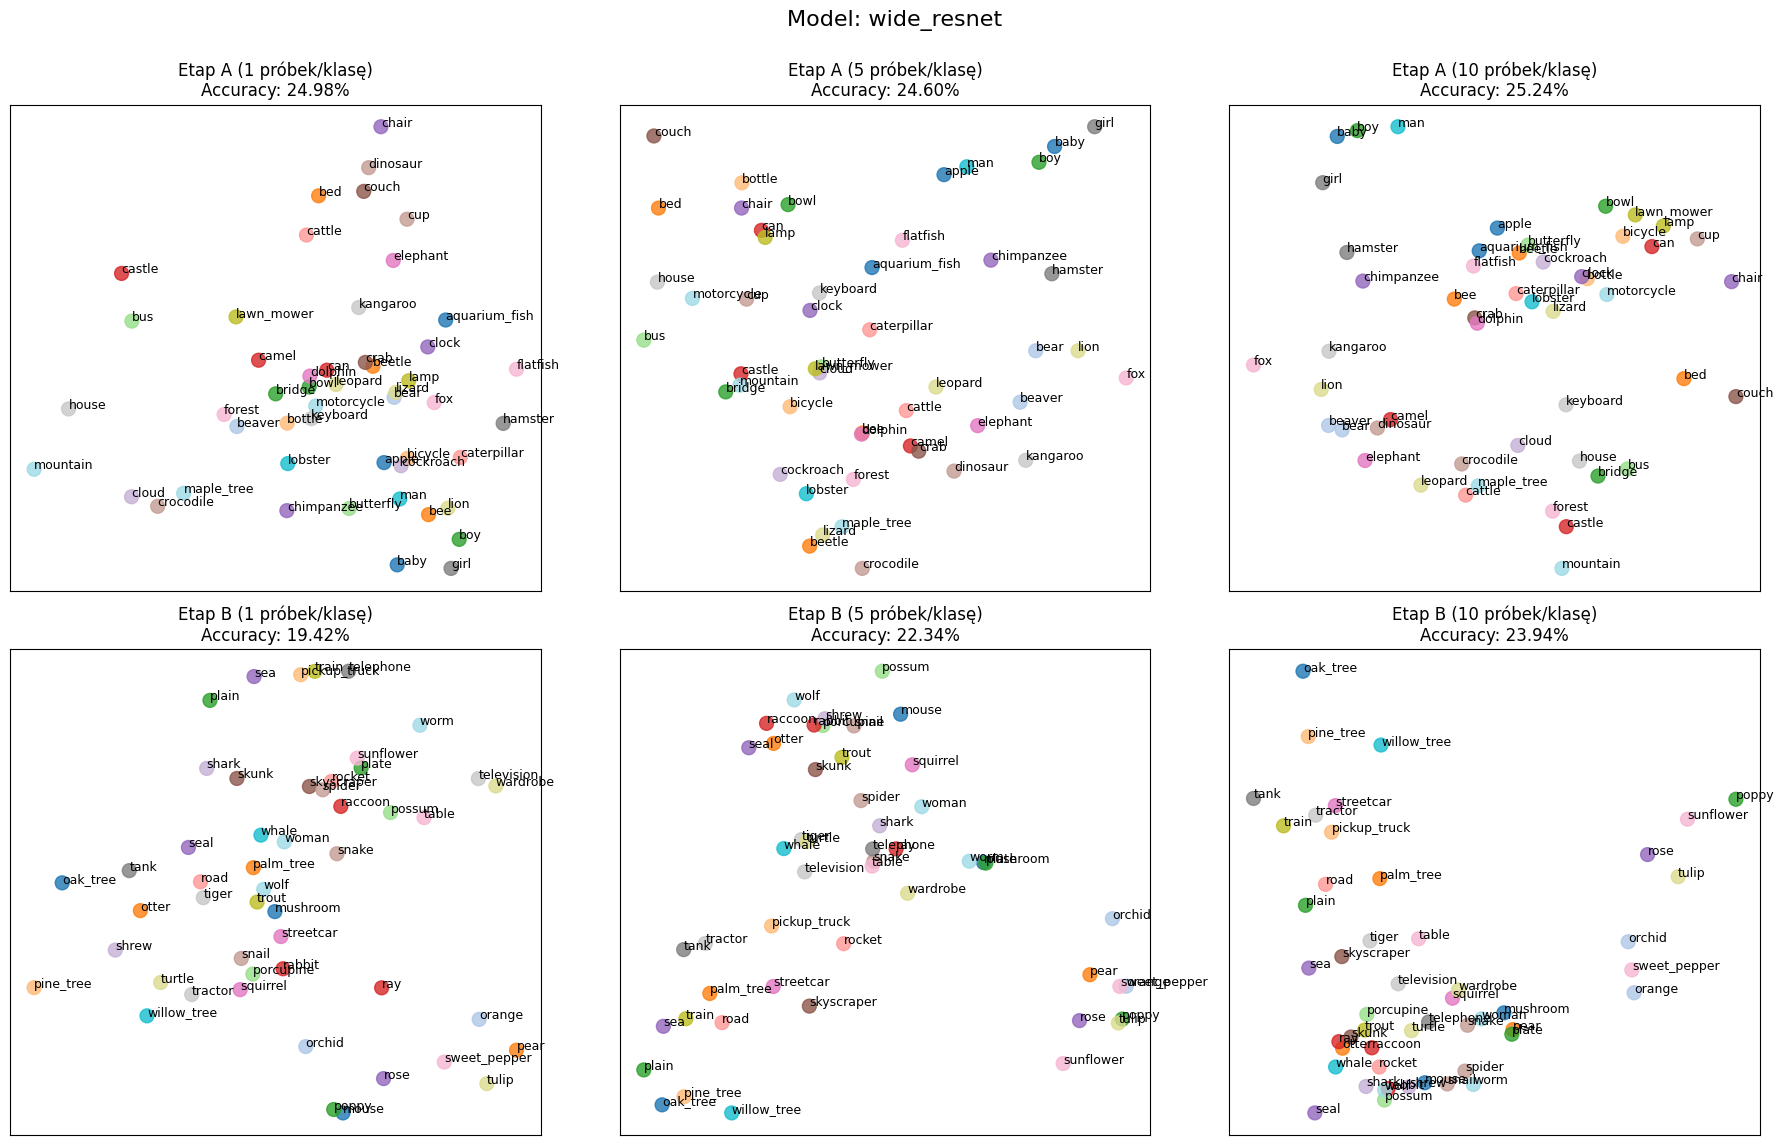

In [ ]:
for model_name in models_names:
    pca_results_A = [None] * len(nums_samples)
    classes_list_A = [None] * len(nums_samples)
    accuracies_A = [None] * len(nums_samples)
    
    pca_results_B = [None] * len(nums_samples)
    classes_list_B = [None] * len(nums_samples)
    accuracies_B = [None] * len(nums_samples)

    # stage A (first, above):
    for idx, num_samples in enumerate(nums_samples):
        
        file_path = os.path.join(base_dir_A, f"{model_name}_{num_samples}_rep.npy")
        loaded_data = np.load(file_path, allow_pickle=True).item()
        
        classes = sorted(loaded_data.keys())
        features = np.array([loaded_data[k] for k in classes])
        
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        
        pca_results_A[idx] = features_pca
        classes_list_A[idx] = classes

        # extract test features from files (it would take too much time if they wasn't stored)
        test_features = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_features.npy")
        test_labels = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_labels.npy")

        accuracies_A[idx] = calculate_accuracy(models[model_name], loaded_data, test_loader, classes_A, test_features, test_labels, 1)

    # stage B:
    for idx, num_samples in enumerate(nums_samples):
        file_path = os.path.join(base_dir_B, f"{model_name}_{num_samples}.npy")        
        loaded_data = np.load(file_path, allow_pickle=True).item()
        
        classes = sorted(loaded_data.keys())
        features = np.array([loaded_data[k] for k in classes])
        
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        
        pca_results_B[idx] = features_pca
        classes_list_B[idx] = classes

        test_features = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_features.npy")
        test_labels = os.path.join(os.path.join("..", "cache"), f"{model_name}_test_labels.npy")

        accuracies_B[idx] = calculate_accuracy(models[model_name], loaded_data, test_loader, classes_B, test_features, test_labels, 1)

    plot_stages(pca_results_A, pca_results_B, classes_list_A, classes_list_B, accuracies_A, accuracies_B, model_name, class_dict)

# Wnioski
Wraz ze zwiększaniem się liczby próbek, accuracy na knn zwiększa się. Ogólnie